In [1]:
# MacOS
!pip install numpy matplotlib torch torchvision torchaudio

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image.shape: torch.Size([1, 28, 28])
Label: 5


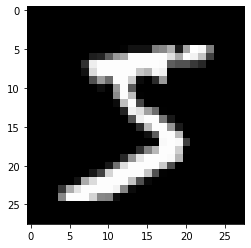

In [4]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

images.shape: torch.Size([128, 1, 28, 28])


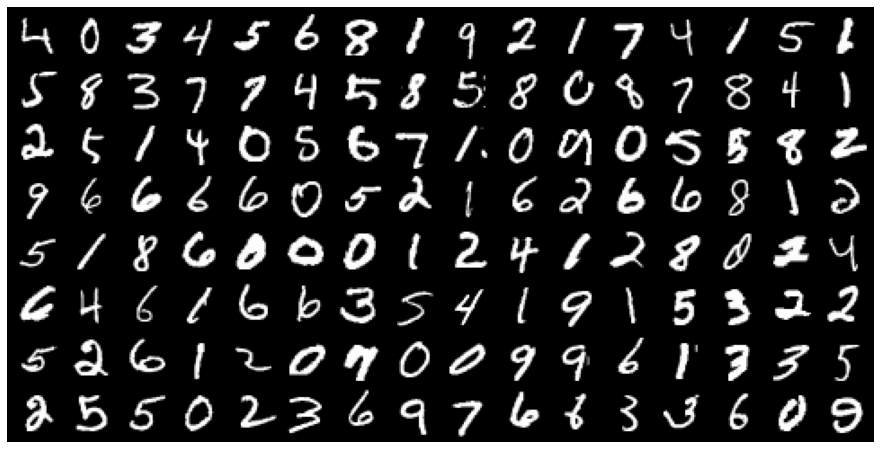

In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [7]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break
    
input_size = inputs.shape[-1]
hidden_size = 512

layer1 = nn.Linear(input_size, hidden_size)

layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

inputs.shape

F.cross_entropy(layer2_outputs, labels)

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])
layer1_outputs.shape: torch.Size([128, 512])
min(layer1_outputs): -0.9620229005813599
min(relu_outputs): 0.0
torch.Size([128, 10])


tensor(2.3139, grad_fn=<NllLossBackward>)

In [8]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.BatchNorm1d(hidden_size), #applying batch norm
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size)
        )
             
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        xb = self.classifier(xb)
        return xb
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
input_size = 784
hidden_size = 512
# hidden_size = 256
# hidden_size = 1024
num_classes = 10

model = MnistModel(input_size, hidden_size=512, out_size=num_classes)

In [11]:
for t in model.parameters():
    print(t.shape)

torch.Size([512, 784])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [12]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.347165584564209
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0934,  0.3631,  0.0934, -0.6571, -0.5371,  0.4271,  0.8300,  0.4026,
          0.2967, -0.3101],
        [ 0.2505,  0.0487, -0.3540, -0.8515, -0.0987, -0.0738,  0.3526,  0.3593,
          0.2387, -0.3864]])


In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [14]:
device = get_default_device()
device

device(type='cpu')

In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [16]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


In [17]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [19]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([9, 7, 6, 8, 6, 4, 3, 1, 1, 1, 2, 1, 7, 2, 7, 8, 4, 0, 0, 2, 5, 2, 4, 1,
        5, 0, 0, 4, 7, 2, 7, 8, 7, 7, 5, 2, 0, 4, 0, 9, 0, 5, 3, 2, 3, 4, 5, 3,
        6, 6, 4, 5, 8, 3, 8, 7, 9, 5, 9, 0, 9, 9, 5, 6, 8, 6, 7, 5, 3, 3, 8, 4,
        8, 7, 0, 4, 5, 3, 5, 2, 3, 7, 1, 0, 1, 4, 9, 7, 5, 7, 4, 4, 1, 1, 1, 4,
        2, 9, 6, 7, 5, 3, 8, 7, 2, 0, 2, 0, 1, 5, 0, 5, 7, 8, 4, 7, 7, 3, 3, 3,
        4, 9, 6, 6, 4, 6, 9, 3, 1, 3, 1, 6, 0, 7, 2, 1, 3, 2, 1, 6, 5, 7, 4, 5,
        8, 8, 8, 4, 5, 5, 2, 3, 8, 8, 9, 2, 6, 6, 5, 4, 3, 5, 7, 0, 1, 3, 8, 2,
        2, 5, 3, 3, 0, 0, 5, 1, 3, 3, 9, 8, 8, 0, 0, 9, 4, 4, 6, 0, 9, 7, 1, 0,
        4, 0, 3, 2, 7, 5, 9, 7, 4, 0, 5, 8, 8, 8, 2, 5, 5, 4, 1, 9, 9, 0, 3, 0,
        2, 9, 4, 0, 4, 2, 9, 9, 3, 1, 2, 9, 5, 0, 7, 8, 5, 2, 6, 6, 3, 2, 9, 3,
        4, 9, 3, 3, 7, 6, 9, 3, 6, 7, 6, 5, 4, 7, 4, 1])


In [20]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [22]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.400238037109375, 'val_acc': 0.09130859375}]

In [23]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1478, val_acc: 0.9521
Epoch [1], val_loss: 0.1097, val_acc: 0.9655
Epoch [2], val_loss: 0.1130, val_acc: 0.9688
Epoch [3], val_loss: 0.0989, val_acc: 0.9744
Epoch [4], val_loss: 0.0786, val_acc: 0.9789


In [24]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0702, val_acc: 0.9820
Epoch [1], val_loss: 0.0711, val_acc: 0.9819
Epoch [2], val_loss: 0.0726, val_acc: 0.9816
Epoch [3], val_loss: 0.0735, val_acc: 0.9815
Epoch [4], val_loss: 0.0741, val_acc: 0.9815


In [25]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0741, val_acc: 0.9815
Epoch [1], val_loss: 0.0742, val_acc: 0.9815
Epoch [2], val_loss: 0.0741, val_acc: 0.9815
Epoch [3], val_loss: 0.0742, val_acc: 0.9815
Epoch [4], val_loss: 0.0746, val_acc: 0.9815


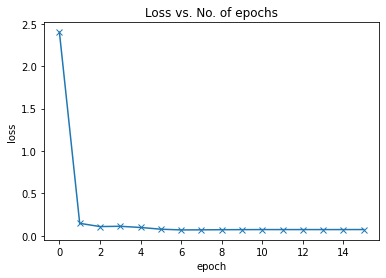

In [32]:
losses1 = [x['val_loss'] for x in history]
plt.plot(losses1, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

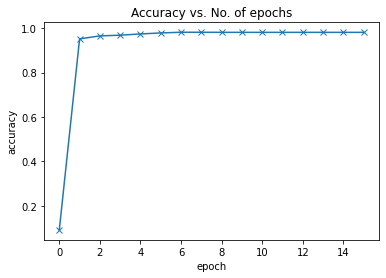

In [33]:
accuracies1 = [x['val_acc'] for x in history]
plt.plot(accuracies1, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');